In [1]:

import scipy.io     # used to load .mat data
from scipy.io import savemat

import pandas as pd
import numpy as np
import pickle as pkl
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import tqdm
import seaborn as sns

from models import MLP, TandemNet, cVAE, cGAN, INN, cVAE_new, cVAE_GSNN, cVAE_Full, cVAE_hybrid, cVAE_tandem
from utils import evaluate_simple_inverse, evaluate_tandem_accuracy, evaluate_vae_inverse, evaluate_vae_minmax_inverse,evaluate_vae_minmax_GSNN_inverse, evaluate_gan_inverse, evaluate_inn_inverse
from utils import evaluate_vae_hybrid_minmax_inverse
from configs import get_configs
from plotting_utils import compare_cie_dist, compare_param_dist, plot_cie, plot_cie_raw_pred
from datasets import get_dataloaders, SiliconColor

from sklearn.metrics import r2_score

#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cpu'
train_loader, val_loader, test_loader = get_dataloaders('tandem_net')

forward_model = MLP(4, 3).to(DEVICE)
forward_model.load_state_dict(torch.load('./models/forward_model_trained.pth')['model_state_dict'])



<All keys matched successfully>

In [1]:
# Define some functions

def plt_hist_all(param, labels, param_raw):
    plt.figure(figsize = [20, 3])
    plt.subplot(1, 4,1)
    plt.hist(param[:,0], bins=20, histtype='step', label=labels+' '+str(int(param_raw[0])))
    plt.title('Height histogram')
    plt.xlabel('Height/(nm)')
    plt.ylabel('Count')
    plt.legend()
    
    plt.subplot(1, 4,2)
    plt.hist(param[:,1], bins=20, histtype='step', label=labels+' '+str(int(param_raw[1])))
    plt.title('Gap histogram')
    plt.xlabel('Gap/(nm)')
    plt.ylabel('Count')
    plt.legend()
    
    plt.subplot(1, 4, 3)
    plt.hist(param[:,2], bins=20, histtype='step', label=labels+' '+str(int(param_raw[2])))
    plt.title('Period histogram')
    plt.xlabel('Period/(nm)')
    plt.ylabel('Count')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.hist(param[:,3], bins=20, histtype='step', label=labels+' '+str(int(param_raw[3])))
    plt.title('Diameter histogram')
    plt.xlabel('Diamater/(nm)')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

        
def plt_hist_all_all(param, labels):
    plt.figure(figsize = [20, 3])
    plt.subplot(1, 4,1)
    plt.hist(param[:,0], bins=20, histtype='step', label=labels)
    plt.title('Height histogram')
    plt.xlabel('Height/(nm)')
    plt.ylabel('Count')
    plt.legend()
    
    plt.subplot(1, 4,2)
    plt.hist(param[:,1], bins=20, histtype='step', label=labels)
    plt.title('Gap histogram')
    plt.xlabel('Gap/(nm)')
    plt.ylabel('Count')
    plt.legend()
    
    plt.subplot(1, 4, 3)
    plt.hist(param[:,2], bins=20, histtype='step', label=labels)
    plt.title('Period histogram')
    plt.xlabel('Period/(nm)')
    plt.ylabel('Count')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.hist(param[:,3], bins=20, histtype='step', label=labels)
    plt.title('Diameter histogram')
    plt.xlabel('Diamater/(nm)')
    plt.ylabel('Count')
    plt.legend()
    plt.show()
    

# GSNN 

In [13]:
# plot the predicted distribution

T = 10 # the first one structure 

total = 1000
param_pred_all = np.zeros([total, 4])
cie_pred_all = np.zeros([total, 3])

configs = get_configs('vae_GSNN')
vae_model = cVAE_GSNN(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_GSNN_trained_4.pth')['model_state_dict'])

for i in range(total):
    cie_raw, param_raw, cie_pred, param_pred =  evaluate_vae_minmax_GSNN_inverse(forward_model, vae_model, configs, test_loader.dataset, show=0)
    cie_pred_all[i,:], param_pred_all[i,:]= cie_pred[T,:], param_pred[T,:]
    

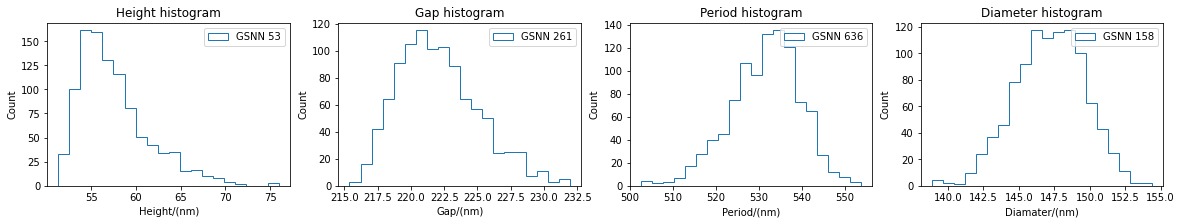

In [14]:
plt_hist_all(param_pred_all, 'GSNN', param_raw[T, :])

# Full 

In [15]:
# plot the predicted distribution

T = 10 # the first one structure 

total = 1000
param_pred_all = np.zeros([total, 4])
cie_pred_all = np.zeros([total, 3])

configs = get_configs('vae_Full')
vae_model = cVAE_Full(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_Full_trained_5.pth')['model_state_dict'])

for i in range(total):
    cie_raw, param_raw, cie_pred, param_pred =  evaluate_vae_minmax_GSNN_inverse(forward_model, vae_model, configs, test_loader.dataset, show=0)
    cie_pred_all[i,:], param_pred_all[i,:]= cie_pred[T,:], param_pred[T,:]

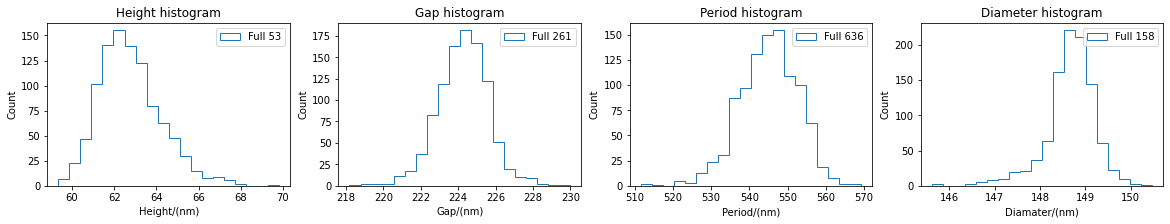

In [16]:
plt_hist_all(param_pred_all, 'Full', param_raw[T, :])

# VAE_tandem

In [17]:
# plot the predicted distribution

T = 10 # the first one structure 

total = 1000
param_pred_all = np.zeros([total, 4])
cie_pred_all = np.zeros([total, 3])

configs = get_configs('vae_tandem')
vae_model = cVAE_tandem(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_tandem_trained_500.pth')['model_state_dict'])

for i in range(total):
    cie_raw, param_raw, cie_pred, param_pred =  evaluate_vae_minmax_GSNN_inverse(forward_model, vae_model, configs, test_loader.dataset, show=0)
    cie_pred_all[i,:], param_pred_all[i,:]= cie_pred[T,:], param_pred[T,:]

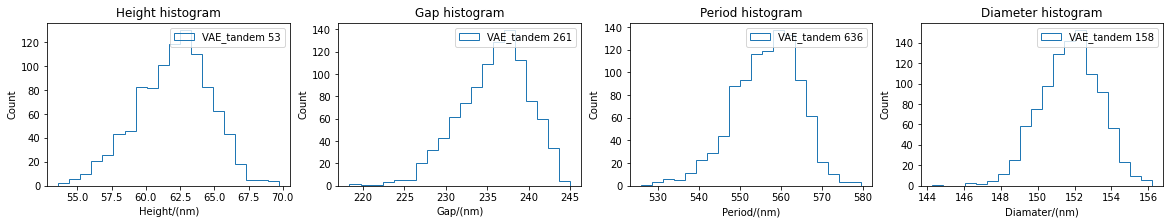

In [18]:
plt_hist_all(param_pred_all, 'VAE_tandem', param_raw[T, :])

# VAE_hybrid

In [19]:
# plot the predicted distribution

T = 10 # the first one structure 

total = 1000
param_pred_all = np.zeros([total, 4])
cie_pred_all = np.zeros([total, 3])


forward_model = MLP(4, 3).to(DEVICE)
forward_model.load_state_dict(torch.load('./models/forward_model_trained.pth')['model_state_dict'])
configs = get_configs('vae_hybrid')
vae_model = cVAE_Full(configs['input_dim'], configs['latent_dim']).to(DEVICE)
vae_model.load_state_dict(torch.load('./models/vae_Full_trained_5.pth')['model_state_dict'])

vae_model = cVAE_hybrid(forward_model, vae_model)

vae_model.load_state_dict(torch.load('./models/vae_hybrid_trained_5_no_pretrained.pth')['model_state_dict'])

for i in range(total):
    cie_raw, param_raw, cie_pred, param_pred =  evaluate_vae_hybrid_minmax_inverse(forward_model, vae_model, configs, test_loader.dataset, show=0)
    cie_pred_all[i,:], param_pred_all[i,:]= cie_pred[T,:], param_pred[T,:]

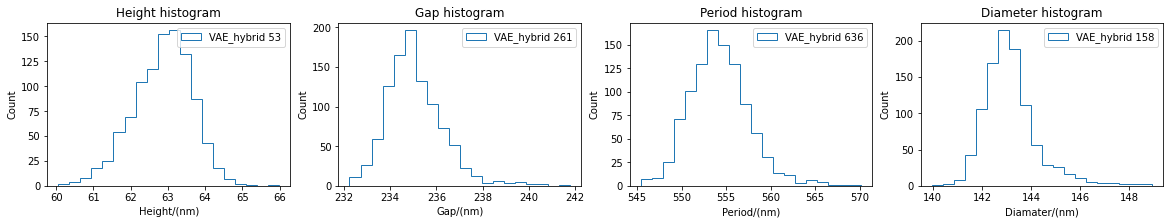

In [20]:
plt_hist_all(param_pred_all, 'VAE_hybrid', param_raw[T, :])